In [2]:
##############
#IMPORTS
%reset
import pickle
import numpy as np
import copy 
from sklearn import decomposition
import os
import matplotlib.pyplot as plt
import yaml
from keras import models
from keras import layers
from keras import optimizers
import tensorflow as tf
from helpers import helper_functions

def load_obj(name):
    with open(name+'.pkl', 'rb') as f:
        return pickle.load(f, encoding='latin1')

# Gaussian normalization, return 0 if std is 0
def normalize(obj, mean, std):
    a = obj-mean
    b=std
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Using TensorFlow backend.


In [101]:
root_dir='/global/cscratch1/sd/al34/autoruns/shuffled_delay_100ms_plus/ncomponents_None_lookback_3_prelayers_2_size_10_rnnsize_20_rnndropout_0_recurrentdropout_0_densedropout_0_delay_10_numfinallayers_0'
#root_dir = "/global/cscratch1/sd/al34/autoruns/shuffled_delay_100ms_plus/ncomponents_None_lookback_3_prelayers_2_size_10_rnnsize_20_rnndropout_0_recurrentdropout_0_densedropout_0_delay_2_numfinallayers_0"

input_dir='/global/homes/a/al34/delayed_data_files/'
model_filename='model.h5'



# load conf file, 'config'
def load_config(config_file):
    with open(config_file) as f:
        config = yaml.load(f)
    return config

config=load_config(os.path.join(root_dir,'conf.yaml'))['data']


In [84]:
helper_functions.preprocess_data(dirname='/global/homes/a/al34/delayed_data_files/', 
                                    sigs_0d=config['sigs_0d'],
                                    sigs_1d=config['sigs_1d'],
                                    sigs_predict=config['sigs_predict'],
                                    n_components=config['n_components'],
                                    avg_window=config['avg_window'],
                                    lookback=config['lookback'],
                                    delay=config['delay'],
                                    train_frac=config['train_frac'],
                                    val_frac=config['val_frac'],
                                    save_data=True, noised_signal = None)

Removed 15 shots with empty arrays
data is not being noised
Number of timesteps in data: 122234
data is not being noised
Number of timesteps in data: 34872
saving data to /global/homes/a/al34/delayed_data_files/...
data saved to /global/homes/a/al34/delayed_data_files/


In [102]:
###############
#LOAD DATA




# load raw data, 'raw_data'
with open(os.path.join(input_dir,'final_data.pkl'), 'rb') as f: 
        raw_data=pickle.load(f, encoding='latin1')
        

# load processed train data, 'train_data'
with open(os.path.join(input_dir,'train_data.pkl'), 'rb') as f: 
        train_data=pickle.load(f, encoding='latin1')
        
        
# load processed val data, 'val_data'
with open(os.path.join(input_dir,'val_data.pkl'), 'rb') as f: 
        val_data=pickle.load(f, encoding='latin1')

# load processed train target, 'train_target'
with open(os.path.join(input_dir,'train_target.pkl'), 'rb') as f: 
        train_target=pickle.load(f, encoding='latin1')

# load processed val target, 'val_target'
with open(os.path.join(input_dir,'val_target.pkl'), 'rb') as f: 
        val_target=pickle.load(f, encoding='latin1')
        

# load processed shot indices, a dictionary, 'shot_dict'
with open(os.path.join(input_dir,'shot_indices.pkl'), 'rb') as f: 
        shot_dict=pickle.load(f, encoding='latin1')


# load model, 'loaded_model'
loaded_model=models.load_model(os.path.join(root_dir,model_filename))

loaded_model.compile(optimizer=optimizers.RMSprop(lr=.001),
                     metrics=['mae'], loss='mse')


# load process true train times, 'train_real_times'
with open(os.path.join(input_dir,'train_time.pkl'), 'rb') as f: 
        train_real_times=pickle.load(f, encoding='latin1')
        
# load process true val times, 'val_real_times'
with open(os.path.join(input_dir,'val_time.pkl'), 'rb') as f: 
        val_real_times=pickle.load(f, encoding='latin1')
        
        
# load standard rho points, 'rho_points'
with open(os.path.join(input_dir,'rho_standard.pkl'), 'rb') as f: 
        rho_points=pickle.load(f, encoding='latin1')
  

# load means and standard deviations of data
means = helper_functions.load_obj(input_dir+'/means')
stds = helper_functions.load_obj(input_dir+'/stds')

In [103]:
#################
#Data organization

#list of all the shots in sorted number, 'train_shot_nums'
train_shot_nums = shot_dict['train_shot_names']

#list of all the shots in sorted number, 'val_shot_nums'
val_shot_nums = shot_dict['val_shot_names']

# list of the indices where each shot begins in the data, 'train_shot_indices'
train_shot_indices = shot_dict['train_shot_indices']

# list of the indices where each shot begins in the data, 'val_shot_indices'
val_shot_indices = shot_dict['val_shot_indices']


# list of 0D and 1D signals, 'sig_keys_0d' and 'sig_keys_1d'
sig_keys_0d = config['sigs_0d'] #['curr_target', 'pinj']
sig_keys_1d = config['sigs_1d'] #['e_temp']

print(sig_keys_0d)
all_sigs = sig_keys_0d+sig_keys_1d




# delay and lookback values
delay = config['delay']
lookback = config['lookback']






['curr_target', 'pinj']


In [104]:

data = val_data

target = val_target

val_mae = abs(loaded_model.predict(data)-target)
avg_val_mae=np.mean(val_mae, axis=0)
std_val_mae=np.std(val_mae, axis=0)



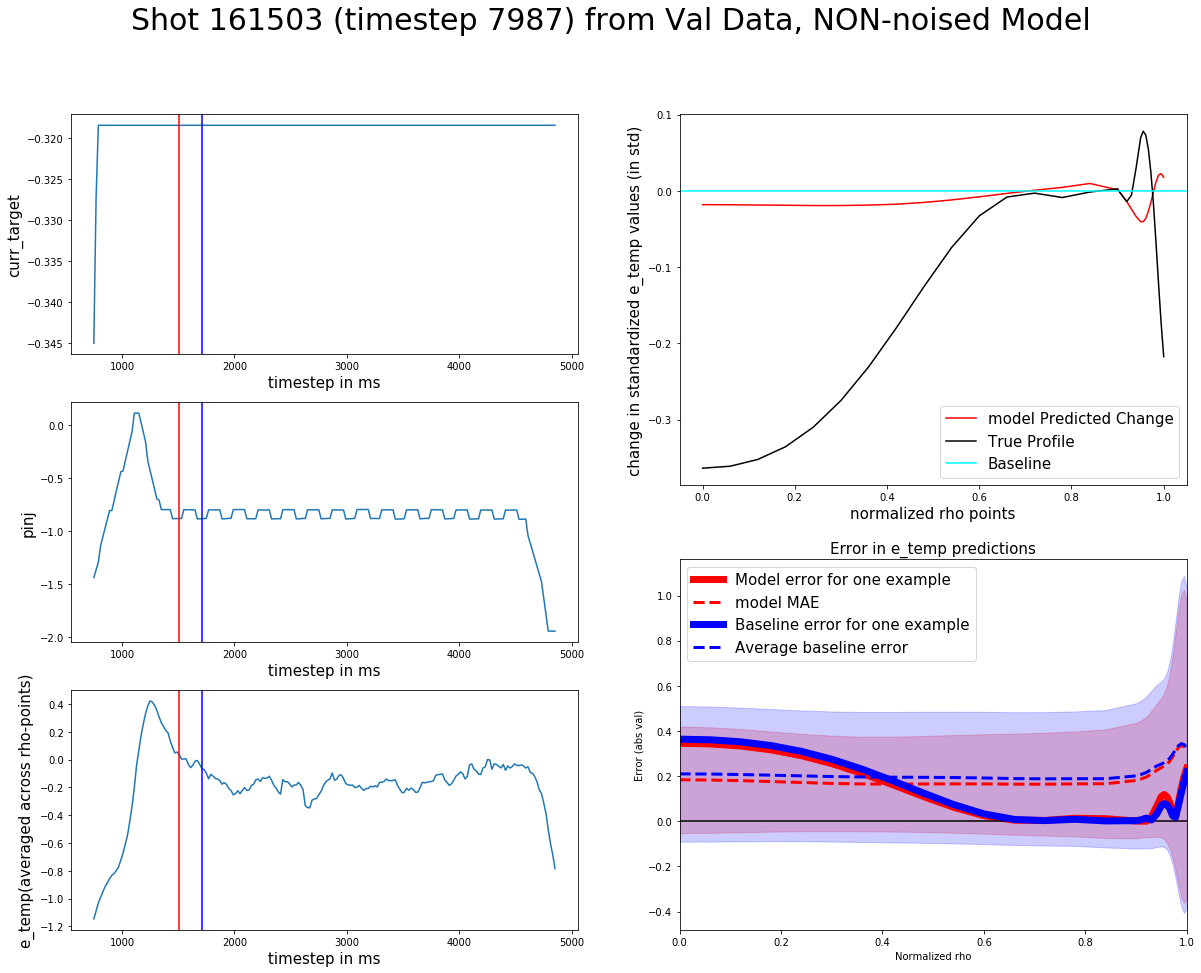

In [211]:
# global and random examples of noised vs no noise model predictions


def diagnostics(timestep, train):
    titlesize = 15
    
    if train:
        shot_indices = train_shot_indices
        data = train_data
        real_times = train_real_times
        shot_nums = train_shot_nums
        target = train_target
        
        
        
    else:
        shot_indices = val_shot_indices
        data = val_data
        real_times = val_real_times
        shot_nums = val_shot_nums
        target = val_target
        
    
    # shot index of timestep 
    shot_index = np.searchsorted(shot_indices, timestep, side='right')-1
    # range of times for that timestep's shot
    timestep_range = list(range(shot_indices[shot_index], shot_indices[shot_index+1]))
    fig = plt.figure(figsize = (20,15))
    
    # plot entire shot history for each 0D sig, with a vertical line symbolizing location 
    # of timestep of interest
    for i in range(len(sig_keys_0d)):
        plot_position = '{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*i+1) 
        tmp_fig = fig.add_subplot(plot_position)
        # get the sig data from the processed data, (which has been shortened by smoothing/lookback)
        sig_data = np.ndarray.flatten(data[timestep_range, lookback, i])
        #joe's version below
        #sig_data=np.array(data)[timestep_range,-delay-1,i].T
        
        
        time_data = real_times[timestep_range]
        
        tmp_fig.plot(time_data, sig_data)
        tmp_fig.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)
        tmp_fig.axvline(real_times[timestep],color='r')
        tmp_fig.axvline(real_times[timestep+delay],color='b')
        
        
    # plot entire shot history for each 1D sig (averaged rho's for each timestep), with a vertical line symbolizing location 
    # of timestep of interest    
    for i in range(len(sig_keys_1d)):
        plot_position = '{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*(len(sig_keys_0d)+i)+1) 
        tmp_fig = fig.add_subplot(plot_position)
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        sig_data = (data[timestep_range, lookback,len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in])
        # average the rho-values across each timestep
        sig_data = (np.mean(sig_data, axis = 1))
        
        
    
        
        
        time_data = real_times[timestep_range]
        tmp_fig.plot(time_data, sig_data)

        tmp_fig.axvline(real_times[timestep],color='r')
        tmp_fig.axvline(real_times[timestep+delay],color='b')
        tmp_fig.set_ylabel(sig_keys_1d[i] + "(averaged across rho-points)", fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)


    
    ##############################################################
    # snapshot noise work
    #plot the prediction profile, the true profile, and the baseline profile
    
    # input_data represents the training data slice for that particular timestep: shape (1, 6, 4)
    input_data=np.array(data)[timestep:timestep+1]
    
    predicted_profile = np.ndarray.flatten(loaded_model.predict(input_data))   
    
    true_profile = target[timestep]
    
    

    
    plot_position = 222
    tmp_fig = fig.add_subplot(plot_position)
    # plot predicted
    tmp_fig.plot(rho_points, predicted_profile, label = "model Predicted Change", color = 'r')
    


  
    
    # add baseline and true target
    # plot true
    tmp_fig.plot(rho_points, true_profile, label = "True Profile", color = 'black')
    # plot baseline (no change)
    tmp_fig.axhline(0,label='Baseline', color='cyan')
    tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)
    tmp_fig.set_ylabel("change in standardized e_temp values (in std)", fontsize=titlesize)
    


    tmp_fig.legend(loc = "best", fontsize=15)
    
#########################################################################################
    # print title out 
    if train:
        data_type = "Train"
    else:
        data_type = "Val"
    fig.suptitle('Shot {} (timestep {}) from {} Data, NON-noised Model'.format(shot_nums[shot_index],timestep, data_type), fontsize = 30)
       
    
    
    #=====================================================================================
    # global and snapshot error work 
    predicted_error = abs(true_profile - predicted_profile)
    baseline_error = abs(true_profile)
    



    
    baseline_mae=abs(target)
    avg_baseline_mae=np.mean(baseline_mae, axis=0)
    std_baseline_mae=np.std(baseline_mae, axis=0)
    

    
    
    
    
    
    # plot predicted, 
    ax = fig.add_subplot('224')
    ax.set_title('Error in e_temp predictions', fontsize=titlesize)
    ax.plot(rho_points, predicted_error, color='red', label='Model error for one example', linewidth=7)
    ax.plot(rho_points, avg_val_mae, color='red', linestyle='--', label='model MAE', linewidth=3)
    ax.fill_between(rho_points,avg_val_mae-std_val_mae, avg_val_mae+std_val_mae, color='red', alpha=.2)
    ax.axhline(0,color='k')
    ax.plot(rho_points, baseline_error, color='b', label='Baseline error for one example', linewidth=7)
    ax.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline error', linewidth=3)
    ax.fill_between(rho_points,avg_baseline_mae-std_baseline_mae, avg_baseline_mae+std_baseline_mae, color='blue', alpha=.2)
    
    


    #ax.set_ylim(0,.25)
    ax.set_xlim(0,1)
    ax.legend(loc='upper left', fontsize=15)
    ax.set_ylabel('Error (abs val)', fontsize=10)
    ax.set_xlabel('Normalized rho', fontsize=10)
        
    
    

    
    

    
# timestep = np.random.choice(train_shot_indices)
#timestep = np.random.choice(val_shot_indices) 
timestep = np.random.choice(range(34148))
timestep = 7987
diagnostics(timestep, False)


#good shots
#1705 rampup
#3860 flatop

#bad 
#13271 rampup
#17360 (flattop)




In [82]:
load_config(os.path.join(root_dir,'conf.yaml'))


{'data': {'avg_window': 10,
  'delay': 10,
  'input_dir_name': '/global/homes/a/al34/data_files/',
  'lookback': 3,
  'n_components': None,
  'name': 'lstm_cnn',
  'noised_signal': None,
  'preprocess': True,
  'sigs_0d': ['curr_target', 'pinj'],
  'sigs_1d': ['e_temp'],
  'sigs_predict': ['e_temp'],
  'train_frac': 0.7,
  'val_frac': 0.2},
 'description': 'LSTM_CNN_MERGE',
 'model': {'cnn_activation': 'linear',
  'cnn_padding': 'same',
  'dense_cnn_activation': 'relu',
  'dense_cnn_size': 10,
  'dense_dropout': 0,
  'dense_final_activation': 'relu',
  'dense_final_size': 40,
  'dense_pre_activation': 'relu',
  'dense_pre_size': 10,
  'include_cnn': False,
  'kernel_size': 10,
  'max_pool_size': 2,
  'name': 'lstm_cnn_merge',
  'num_dense_cnn_layers': 0,
  'num_filters': 2,
  'num_final_layers': 0,
  'num_pre_layers': 2,
  'recurrent_dropout': 0,
  'rho_length_out': 30,
  'rnn_activation': 'relu',
  'rnn_dropout': 0,
  'rnn_size': 20,
  'rnn_type': 'LSTM'},
 'optimizer': {'lr': 0.001, 

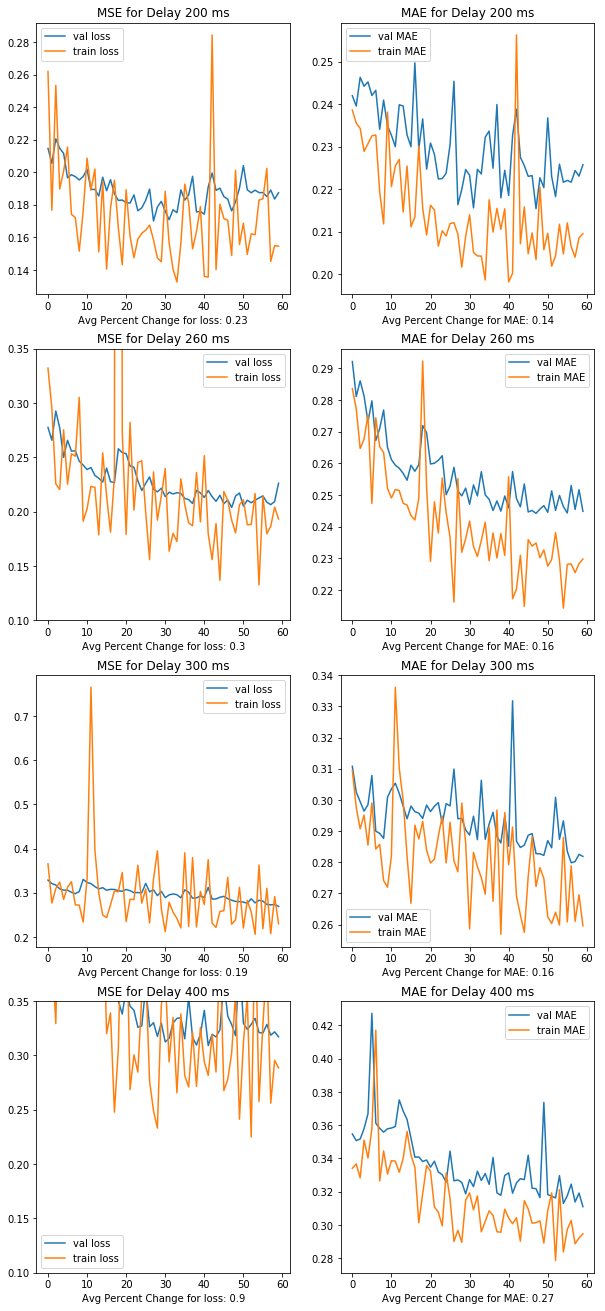

In [4]:


delay = 2
width = 10
delays = [10, 13, 15, 20]
fig = plt.figure(figsize = (width, 23))


for index, delay in enumerate(delays):
    new_dir = "/global/cscratch1/sd/al34/autoruns/shuffled_delay_100ms_plus/ncomponents_None_lookback_3_prelayers_2_size_10_rnnsize_20_rnndropout_0_recurrentdropout_0_densedropout_0_delay_{}_numfinallayers_0".format(delay)
    # load_config(os.path.join(new_dir,'conf.yaml'))
    

    history = np.load(os.path.join(new_dir, 'history.npz'))
    plot_position = "{}2{}".format(len(delays), 2*index+1)
    #print(plot_position)

    tmp_fig = fig.add_subplot(plot_position)
    tmp_fig.plot(history['val_loss'], label = "val loss")
    tmp_fig.plot(history['loss'], label = 'train loss')
    tmp_fig.legend()
    # tmp_fig.set_ylim(0.1,0.35)
    tmp_fig.set_title("MSE for Delay {} ms".format(delay*20))
    if(np.max(history['loss'])>1):
        tmp_fig.set_ylim(0.1,0.35)
    percent_change = (np.max(history['val_loss'])-np.min(history['val_loss']))/np.max(history['val_loss'])
    tmp_fig.set_xlabel("Avg Percent Change for loss: {}".format(round(percent_change,2)))

    plot_position = "{}2{}".format(len(delays), 2*index+2)
    #print(plot_position)
    tmp_fig = fig.add_subplot(plot_position)
    tmp_fig.plot(history['val_mean_absolute_error'], label = "val MAE")
    tmp_fig.plot(history['mean_absolute_error'], label = 'train MAE')
    tmp_fig.legend()
    tmp_fig.set_title("MAE for Delay {} ms".format(delay*20))
    
    percent_change = (np.max(history['val_mean_absolute_error'])-np.min(history['val_mean_absolute_error']))/np.max(history['val_mean_absolute_error'])
    tmp_fig.set_xlabel("Avg Percent Change for MAE: {}".format(round(percent_change, 2)))
    
    


In [214]:
import re
min_val_mae_array = []
delays = [2, 3, 8, 10, 13]
new_delays = np.multiply(delays, 20)
baselines_array = []
for delay in delays:
    new_dir = "/global/cscratch1/sd/al34/autoruns/shuffled_delay_100ms_plus/ncomponents_None_lookback_3_prelayers_2_size_10_rnnsize_20_rnndropout_0_recurrentdropout_0_densedropout_0_delay_{}_numfinallayers_0".format(delay)
    # load_config(os.path.join(new_dir,'conf.yaml'))
    with open(os.path.join(new_dir, 'log.out')) as f:
            now = False
            for line in f:
                if now:
                    m = re.search('0\..*',line)
                    baseline_mae = m.group(0)
                    break
                if re.search('(?<=0: baseline mae average:)',line):
                    now = True
            baselines_array.append((baseline_mae))

    

    history = np.load(os.path.join(new_dir, 'history.npz'))
    min_val_mae_array.append(np.min(history['val_mean_absolute_error']))
    
# plt.scatter(new_delays, min_val_loss_array)
# plt.ylabel("lowest val mean abs error out of all epochs")
# plt.xlabel("Delay timestep (ms)")


    



array([ 0.06542969,  0.09178842,  0.20065986,  0.23582238,  0.27510301])

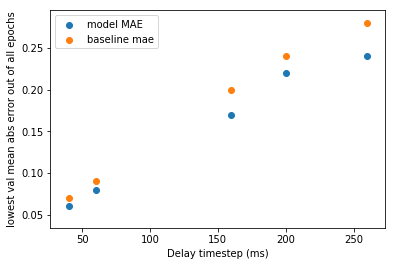

In [215]:
baselines_array = np.array(baselines_array)
baselines_array = baselines_array.astype(np.float)
    

plt.scatter(new_delays, np.round(min_val_mae_array,2), label = "model MAE")
plt.ylabel("lowest val mean abs error out of all epochs")
plt.xlabel("Delay timestep (ms)")
plt.scatter(new_delays, np.round(baselines_array,2), label = "baseline mae")
plt.legend(loc="best")

baselines_array
